In [1]:
# This section of the code is for all of my imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
from datetime import datetime
import glob
import matplotlib.cm as cm

# This allows me to access my flash drive that im working off of
os.chdir('/Volumes/Flash Drive')

In [2]:
# This section loads all CSV files from the directory

Path = '/Volumes/Flash Drive/Saturns rings Research/Data From Center of Ringlets CSV files/Ringlet Edges'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(Path, '*.csv'))

print(f"Found {len(csv_files)} CSV files:")
for csv_file in csv_files:
    print(f"  - {os.path.basename(csv_file)}")

Found 12 CSV files:
  - BetCen_075I_1km_ringlet_threshold_data.csv
  - BetCen_077E_1km_ringlet_threshold_data.csv
  - BetCen_077I_1km_ringlet_threshold_data.csv
  - BetCen_078E_1km_ringlet_threshold_data.csv
  - BetCen_081I_1km_ringlet_threshold_data.csv
  - BetCen_085I_1km_ringlet_threshold_data.csv
  - BetCen_089I_1km_ringlet_threshold_data.csv
  - BetCen_092E_1km_ringlet_threshold_data.csv
  - BetCen_096I_1km_ringlet_threshold_data.csv
  - BetCen_102I_1km_ringlet_threshold_data.csv
  - BetCen_104E_1km_ringlet_threshold_data.csv
  - BetCen_104I_1km_ringlet_threshold_data.csv


In [3]:
# This Section is the formulas to convert from UTC to ET time, im working off of ET time

# This formula gets the UTC and ET offset due to leap seconds, number is in seconds
def utc_to_et_offset(year):
    """
    Get the offset between UTC and ET (TDB) in seconds for 2008.
    
    For 2008:
    - Leap seconds accumulated by 2008: 33 seconds
    - TT-TAI offset: 32.184 seconds
    - ET ≈ TDB ≈ TT for most purposes
    - So ET - UTC ≈ 33 + 32.184 = 65.184 seconds
    """
    
    ls = 33  # Leap Seconds since 2008

    # TT - TAI offset is always 32.184 seconds
    tt_tai_offset = 32.184
    
    # ET ≈ TDB ≈ TT = UTC + leap_seconds + 32.184
    et_utc_offset = ls + tt_tai_offset
    
    return et_utc_offset # Seconds

# This section of the code converts the UTC Julian Date to ET Julian Date adding in the leap seconds offset
def convert_paper_time_to_et(jd_utc):
    """
    Convert the paper's UTC-based Julian Date to ET-based Julian Date.
    
    Parameters:
    -----------
    jd_utc : float
        Julian Date in UTC (as used in the paper)
    
    Returns:
    --------
    jd_et : float
        Julian Date in Ephemeris Time
    """
    
    # Get offset for 2008
    et_utc_offset_2008 = utc_to_et_offset(2008)
    
    # Convert to ET
    initial_time = jd_utc + (et_utc_offset_2008 / 86400.0)
    
    return initial_time # Seconds


In [4]:
# This section defines the True Anamoly formula and the radius formula

def calculate_radius_true_anomaly(a, e, true_anomaly):
    """
    Calculate the radius at a given true anomaly for a Keplerian ellipse.
    
    This implements equation (2) from the paper:
    r(λ,t) = a(1 - e²) / (1 + e·cos(f))
    f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    a : float
        Semi-major axis (km)
    e : float
        Eccentricity (dimensionless, between 0 and 1)
    true_anomaly : float or array
        True anomaly f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
        where λ is the inertial longitude and ϖ is the longitude of periapse
    
    Returns:
    --------
    r : float or array
        Radius at the given true anomaly (km)
    """

        # Convert to radians
    #true_anomaly = true_anomaly * np.pi / 180
    
    # Calculate the numerator: a(1 - e²)
    numerator = a * (1 - e**2)
    
    # Calculate the denominator: 1 + e·cos(f)
    denominator = 1 + e * np.cos(true_anomaly)
    
    # Calculate radius
    r = numerator / denominator
    
    return r

def calculate_true_anomaly(longitude #Inertial longitude (LON value)
                           ,varpi_0 # Longitude periapse (Fixed)
                           ,varpi_dot #Rrecession rate (Fixed)
                           ,time # Time from data
                           ,initial_time): # Time from paper (fixed)
    """
    Calculate the true anomaly from orbital parameters.
    
    From the paper: f = λ - ϖ = λ - ϖ₀ - ϖ̇(t - t₀)
    
    Parameters:
    -----------
    longitude : float or array
        Inertial longitude λ (degrees)
    varpi_0 (Longitude periapse) : float
        Longitude of periapse at epoch ϖ₀ (degrees)
    varpi_dot (precession rate) : float, optional
        Apsidal precession rate ϖ̇ (degrees/day)
    time : float, optional
        Current time (days)
    initial_time : float, optional
        Epoch time t₀ (days)
    
    Returns:
    --------
    true_anomaly : float or array
        True anomaly f (degrees)
    """
    
    # True anomaly is the angle from periapse
    true_anomaly = longitude - varpi_0 - varpi_dot * (time - initial_time)

    # Wrap to 0-360 degrees
    true_anomaly = true_anomaly % 360
    
    return true_anomaly

def plot_r_vs_true_anomaly(true_anomaly, radii, title=f"\Radius vs True Anomaly Analysis of Titan Ringlet \n File: {csv_files}"):
    """
    Plot radius vs true anomaly.
    
    Parameters:
    -----------
    true_anomaly : array
        True anomaly values in degrees
    radii : array
        Radius values in km
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(true_anomaly, radii, 'b-', linewidth=2)
    plt.xlabel('True Anomaly, f (degrees)')
    plt.ylabel('Radius (km)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
# This section defines static parameters and initializes data storage

# J2000 epoch = JD 2451545.0
j2000_jd = 2451545.0

# Paper's epoch
paper_epoch_utc = 2454467.0  # This is in UTC

# Paper's epoch conversion to ET (seconds)
paper_epoch_jd_et = convert_paper_time_to_et(paper_epoch_utc)

# Static orbital parameters/Paper values (these don't change between occultations)
a_paper = 77878.67  # km
e_paper = 2.88*10**-4
aeI = 17.39    # ae Inner
aeO = 27.20    # ae Outer
varpi_0I = 270.54  # degrees Inner
varpi_0O = 270.70  # degrees Outer
varpi_dotI = 22.57503  # ϖ̇ in degrees/day Inner
varpi_dotO = 22.57562  # ϖ̇ in degrees/day Outer

# Initialize lists to store data points from all occultations
# Separate lists for inner and outer edges
all_true_anomaly_inner = []
all_radii_inner = []
all_longitudes_inner = []
all_times_inner = []
all_TAUPLUS_inner = []
all_TAUMINUS_inner = []
all_true_anomaly_outer = []
all_radii_outer = []
all_longitudes_outer = []
all_times_outer = []
all_TAUPLUS_outer = []
all_TAUMINUS_outer = []
all_csv_names = []

In [6]:
# This section loops through all CSV files and processes each one for Titan Ringlet
print(f"\nProcessing {len(csv_files)} CSV files...\n")

for csv_file in csv_files:
    csv_name = os.path.basename(csv_file)
    print(f"Processing: {csv_name}")
    
    try:
        # Load data from CSV
        data = pd.read_csv(csv_file)
        
        # Get Titan inner and outer edge data
        titan_inner = data[data['Ringlet_Position'] == 'Titan_Inner']
        titan_outer = data[data['Ringlet_Position'] == 'Titan_Outer']
        
        if len(titan_inner) == 0 and len(titan_outer) == 0:
            print(f"  ⚠ No Titan ringlet data found in {csv_name}")
            continue
        
        # Process Inner Edge
        if len(titan_inner) > 0:
            # Extract radius value from CSV for inner edge
            a_inner = titan_inner['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_inner = aeI / a_inner
            
            # Get longitude from data
            longitude_inner = titan_inner['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_inner = titan_inner['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_inner = titan_inner['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            titan_et_days_inner = titan_inner['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            titan_jd_et_inner = j2000_jd + titan_et_days_inner
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_inner = calculate_true_anomaly(longitude_inner, varpi_0I, varpi_dotI, 
                                                 titan_jd_et_inner, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_inner = true_anomaly_inner * np.pi / 180
            
            # Calculate radii
            radii_inner = calculate_radius_true_anomaly(a_inner, e_inner, true_anomaly_rad_inner)
            
            # Store inner edge data points
            all_true_anomaly_inner.append(true_anomaly_inner)
            all_radii_inner.append(radii_inner)
            all_longitudes_inner.append(longitude_inner)
            all_times_inner.append(titan_jd_et_inner)
            all_TAUPLUS_inner.append(TAUPLUS_inner)
            all_TAUMINUS_inner.append(TAUMINUS_inner)
            
            print(f"  ✓ Inner edge: a = {a_inner:.2f} km")
        
        # Process Outer Edge
        if len(titan_outer) > 0:
            # Extract radius value from CSV for outer edge
            a_outer = titan_outer['Radius'].values[0]
            
            # Calculate eccentricity (using ae from paper then using our radial value)
            e_outer = aeO / a_outer
            
            # Get longitude from data
            longitude_outer = titan_outer['LON'].values[0]  # LON in degrees

            # Get TAUPLUS from data
            TAUPLUS_outer = titan_outer['TAUPLUS'].values[0]  # TAUPLUS

            # Get TAUMINUS from data
            TAUMINUS_outer = titan_outer['TAUMINUS'].values[0]  # TAUMINUS
            
            # Convert ET time from seconds to days
            titan_et_days_outer = titan_outer['ET'].values[0] / 86400.0
            
            # Convert to Julian Days
            titan_jd_et_outer = j2000_jd + titan_et_days_outer
            
            # Calculate true anomaly (comes out in degrees after wrapping)
            true_anomaly_outer = calculate_true_anomaly(longitude_outer, varpi_0O, varpi_dotO, 
                                                 titan_jd_et_outer, paper_epoch_jd_et)
            
            # Convert to radians before calculating radius
            true_anomaly_rad_outer = true_anomaly_outer * np.pi / 180
            
            # Calculate radii
            radii_outer = calculate_radius_true_anomaly(a_outer, e_outer, true_anomaly_rad_outer)
            
            # Store outer edge data points
            all_true_anomaly_outer.append(true_anomaly_outer)
            all_radii_outer.append(radii_outer)
            all_longitudes_outer.append(longitude_outer)
            all_times_outer.append(titan_jd_et_outer)
            all_TAUPLUS_outer.append(TAUPLUS_outer)
            all_TAUMINUS_outer.append(TAUMINUS_outer)
            
            print(f"  ✓ Outer edge: a = {a_outer:.2f} km")
        
        all_csv_names.append(csv_name)
        
    except Exception as ex:
        print(f"  ✗ Error processing {csv_name}: {ex}")
        import traceback
        traceback.print_exc()
        continue

# Convert lists to numpy arrays
all_true_anomaly_inner = np.array(all_true_anomaly_inner)
all_radii_inner = np.array(all_radii_inner)
all_longitudes_inner = np.array(all_longitudes_inner)
all_times_inner = np.array(all_times_inner)
all_TAUPLUS_inner = np.array(all_TAUPLUS_inner)
all_TAUMINUS_inner = np.array(all_TAUMINUS_inner)

all_true_anomaly_outer = np.array(all_true_anomaly_outer)
all_radii_outer = np.array(all_radii_outer)
all_longitudes_outer = np.array(all_longitudes_outer)
all_times_outer = np.array(all_times_outer)
all_TAUPLUS_outer = np.array(all_TAUPLUS_outer)
all_TAUMINUS_outer = np.array(all_TAUMINUS_outer)

print(f"\n{'='*60}")
print(f"TOTAL DATA POINTS COLLECTED:")
print(f"  Inner edge: {len(all_true_anomaly_inner)} points")
print(f"  Outer edge: {len(all_true_anomaly_outer)} points")
print(f"  Total: {len(all_true_anomaly_inner) + len(all_true_anomaly_outer)} points")
print(f"  Total Tau+- values Inner: {len(all_TAUPLUS_inner) + len(all_TAUMINUS_inner)} points")
print(f"  Total Tau+- values Outer: {len(all_TAUPLUS_outer) + len(all_TAUMINUS_outer)} points")
print(f"{'='*60}")

if len(all_true_anomaly_inner) > 0:
    print(f"Inner - True anomaly: {np.min(all_true_anomaly_inner):.2f}° to {np.max(all_true_anomaly_inner):.2f}°")
    print(f"Inner - Radii: {np.min(all_radii_inner):.2f} to {np.max(all_radii_inner):.2f} km")

if len(all_true_anomaly_outer) > 0:
    print(f"Outer - True anomaly: {np.min(all_true_anomaly_outer):.2f}° to {np.max(all_true_anomaly_outer):.2f}°")
    print(f"Outer - Radii: {np.min(all_radii_outer):.2f} to {np.max(all_radii_outer):.2f} km")


Processing 12 CSV files...

Processing: BetCen_075I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77856.00 km
  ✓ Outer edge: a = 77865.00 km
Processing: BetCen_077E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77874.00 km
  ✓ Outer edge: a = 77895.00 km
Processing: BetCen_077I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77847.00 km
  ✓ Outer edge: a = 77863.00 km
Processing: BetCen_078E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77870.00 km
  ✓ Outer edge: a = 77893.00 km
Processing: BetCen_081I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77866.00 km
  ✓ Outer edge: a = 77884.00 km
Processing: BetCen_085I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77878.00 km
  ✓ Outer edge: a = 77909.00 km
Processing: BetCen_089I_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77882.00 km
  ✓ Outer edge: a = 77913.00 km
Processing: BetCen_092E_1km_ringlet_threshold_data.csv
  ✓ Inner edge: a = 77861.00 km
  ✓ Outer edge: a = 77888.00 km
Processing: BetCen_

In [7]:
""" # This part creates the model curve using paper parameters (Might not need commenting out for now)

# Create model curve (sampling all true anomalies)
true_anomaly_deg_model = np.linspace(0, 360, 1000)
true_anomaly_rad_model = true_anomaly_deg_model * np.pi / 180

# Paper parameters for model
a_paper = 77867.13  # km
ae_paper = 17.39    # km 
e_paper = ae_paper / a_paper

model_radii = calculate_radius_true_anomaly(a_paper, e_paper, true_anomaly_rad_model)

print(f"Model parameters:")
print(f"  a_paper = {a_paper} km")
print(f"  e_paper = {e_paper:.6f}")
print(f"  Model radius range: {np.min(model_radii):.2f} to {np.max(model_radii):.2f} km")
"""

' # This part creates the model curve using paper parameters (Might not need commenting out for now)\n\n# Create model curve (sampling all true anomalies)\ntrue_anomaly_deg_model = np.linspace(0, 360, 1000)\ntrue_anomaly_rad_model = true_anomaly_deg_model * np.pi / 180\n\n# Paper parameters for model\na_paper = 77867.13  # km\nae_paper = 17.39    # km \ne_paper = ae_paper / a_paper\n\nmodel_radii = calculate_radius_true_anomaly(a_paper, e_paper, true_anomaly_rad_model)\n\nprint(f"Model parameters:")\nprint(f"  a_paper = {a_paper} km")\nprint(f"  e_paper = {e_paper:.6f}")\nprint(f"  Model radius range: {np.min(model_radii):.2f} to {np.max(model_radii):.2f} km")\n'

In [8]:
# Initial approximate locations of the ringlets (Hardcoded)
saturn_ringlets_approx = {
    'Titan': 77883,      # Colombo Gap - looks accurate in the plot around 77500-78000
    'Maxwell': 87500,    # Maxwell Gap - appears correct around 87000-87500
    'Bond': 88710,       # Bond Ringlet - looks close, around 88500-89000
    'Huygens': 117800,   # Huygens Gap - in the inset, appears around 117500
    'Dawes': 90210       # Dawes Ringlet - appears around 90000-90500
}

# Path to the directory containing all occultation files
data_directory = '/Volumes/Flash Drive/Saturns rings Research/Data/BetCen Occultations'

# Find all .sav files matching the pattern
occultation_files = glob.glob(os.path.join(data_directory, 'BetCen_*_1km.sav'))

# Sort the files for consistent ordering
occultation_files.sort()

print(f"Found {len(occultation_files)} occultation files:")
for file in occultation_files:
    print(f"  - {os.path.basename(file)}")

# Dictionary to store all extracted data
all_occultation_data = {}

# Loop through each occultation file
for file_path in occultation_files:
    # Extract the occultation identifier (e.g., '064E', '105I', etc.)
    filename = os.path.basename(file_path)
    occultation_id = filename.split('_')[1]  # Gets '064E' from 'BetCen_064E_1km.sav'
    
    print(f"\nProcessing {filename}...")
    
    try:
        # Read the .sav file
        test = sio.readsav(file_path)
        
        # Extract the data structure
        pdsdata = test['pdsdata'][0]
        
        # Get radius and tau
        radius = pdsdata['RADIUS']
        tau = pdsdata['TAU']
        
        # Store the data in the dictionary
        all_occultation_data[occultation_id] = {
            'filename': filename,
            'radius': radius,
            'tau': tau,
            'full_data': pdsdata  # Store full data structure if you need other fields
        }
        
        print(f"  ✓ Successfully extracted data: {len(radius)} data points")
        
    except Exception as e:
        print(f"  ✗ Error processing {filename}: {e}")

print(f"\n{'='*60}")
print(f"Extraction complete! Total occultations loaded: {len(all_occultation_data)}")
print(f"{'='*60}")

# Example: Loop through all occultations
for occ_id, data in all_occultation_data.items():
    print(f"{occ_id}: {len(data['radius'])} data points")

Found 12 occultation files:
  - BetCen_075I_1km.sav
  - BetCen_077E_1km.sav
  - BetCen_077I_1km.sav
  - BetCen_078E_1km.sav
  - BetCen_081I_1km.sav
  - BetCen_085I_1km.sav
  - BetCen_089I_1km.sav
  - BetCen_092E_1km.sav
  - BetCen_096I_1km.sav
  - BetCen_102I_1km.sav
  - BetCen_104E_1km.sav
  - BetCen_104I_1km.sav

Processing BetCen_075I_1km.sav...
  ✓ Successfully extracted data: 72021 data points

Processing BetCen_077E_1km.sav...
  ✓ Successfully extracted data: 70179 data points

Processing BetCen_077I_1km.sav...
  ✓ Successfully extracted data: 71561 data points

Processing BetCen_078E_1km.sav...
  ✓ Successfully extracted data: 86554 data points

Processing BetCen_081I_1km.sav...
  ✓ Successfully extracted data: 78863 data points

Processing BetCen_085I_1km.sav...
  ✓ Successfully extracted data: 70303 data points

Processing BetCen_089I_1km.sav...
  ✓ Successfully extracted data: 70032 data points

Processing BetCen_092E_1km.sav...
  ✓ Successfully extracted data: 103898 data po

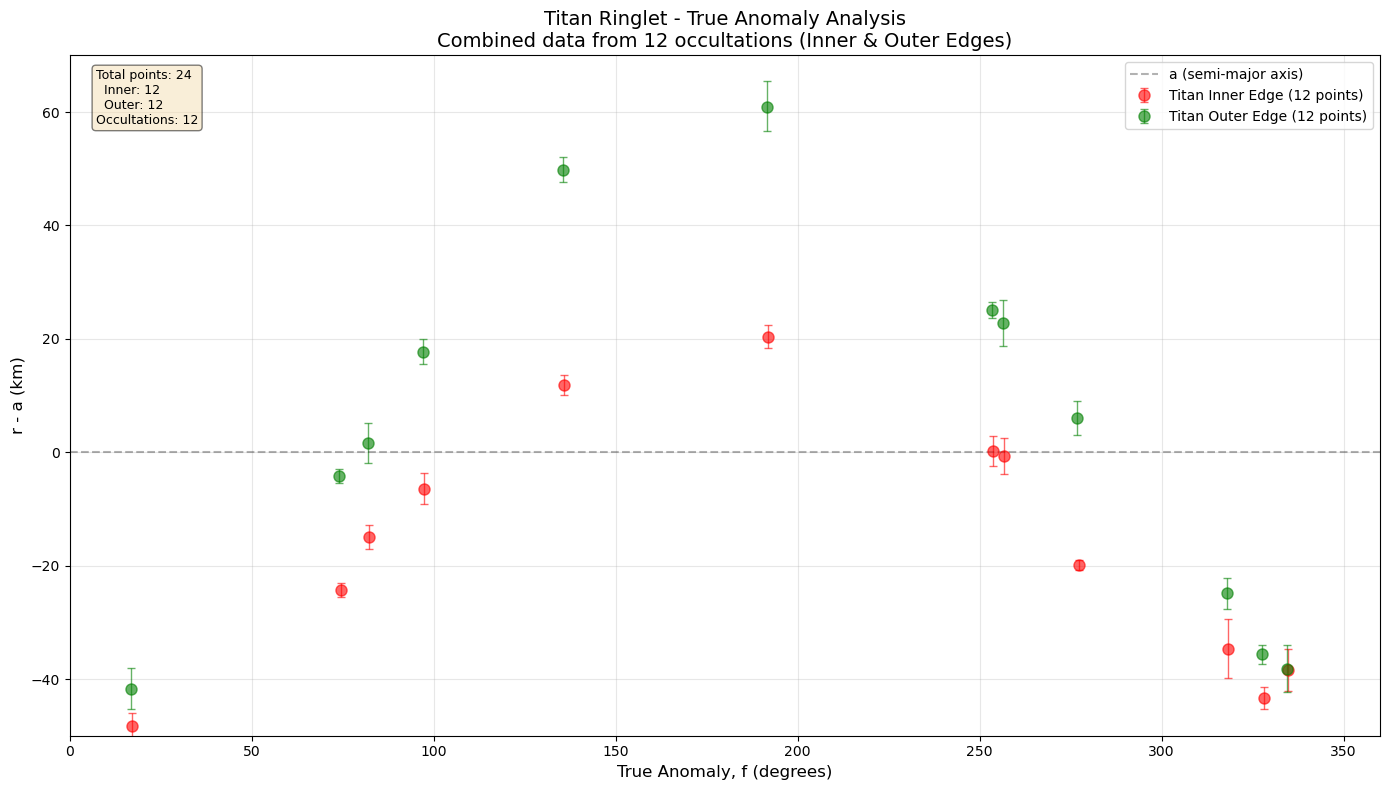


Plot generated with 24 total data points from 12 CSV files
  - Inner edge: 12 points (red circles)
  - Outer edge: 12 points (green squares)


In [9]:
# This section plots the model curve with ALL data points from all occultations for Titan ringlet

plt.figure(figsize=(14, 8))

# Plot inner edge data points with error bars (red circles)
plt.errorbar(all_true_anomaly_inner, all_radii_inner - a_paper, 
             yerr=[all_TAUMINUS_inner, all_TAUPLUS_inner],  # Asymmetric error bars
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1)

# Plot outer edge data points with error bars (green circles)
plt.errorbar(all_true_anomaly_outer, all_radii_outer - a_paper, 
             yerr=[all_TAUMINUS_outer, all_TAUPLUS_outer],  # Asymmetric error bars
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('r - a (km)', fontsize=12)
plt.title(f'Titan Ringlet - True Anomaly Analysis\nCombined data from {len(all_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 360)
plt.ylim(-50, 70)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {total_points} total data points from {len(all_csv_names)} CSV files")
print(f"  - Inner edge: {len(all_true_anomaly_inner)} points (red circles)")
print(f"  - Outer edge: {len(all_true_anomaly_outer)} points (green squares)")

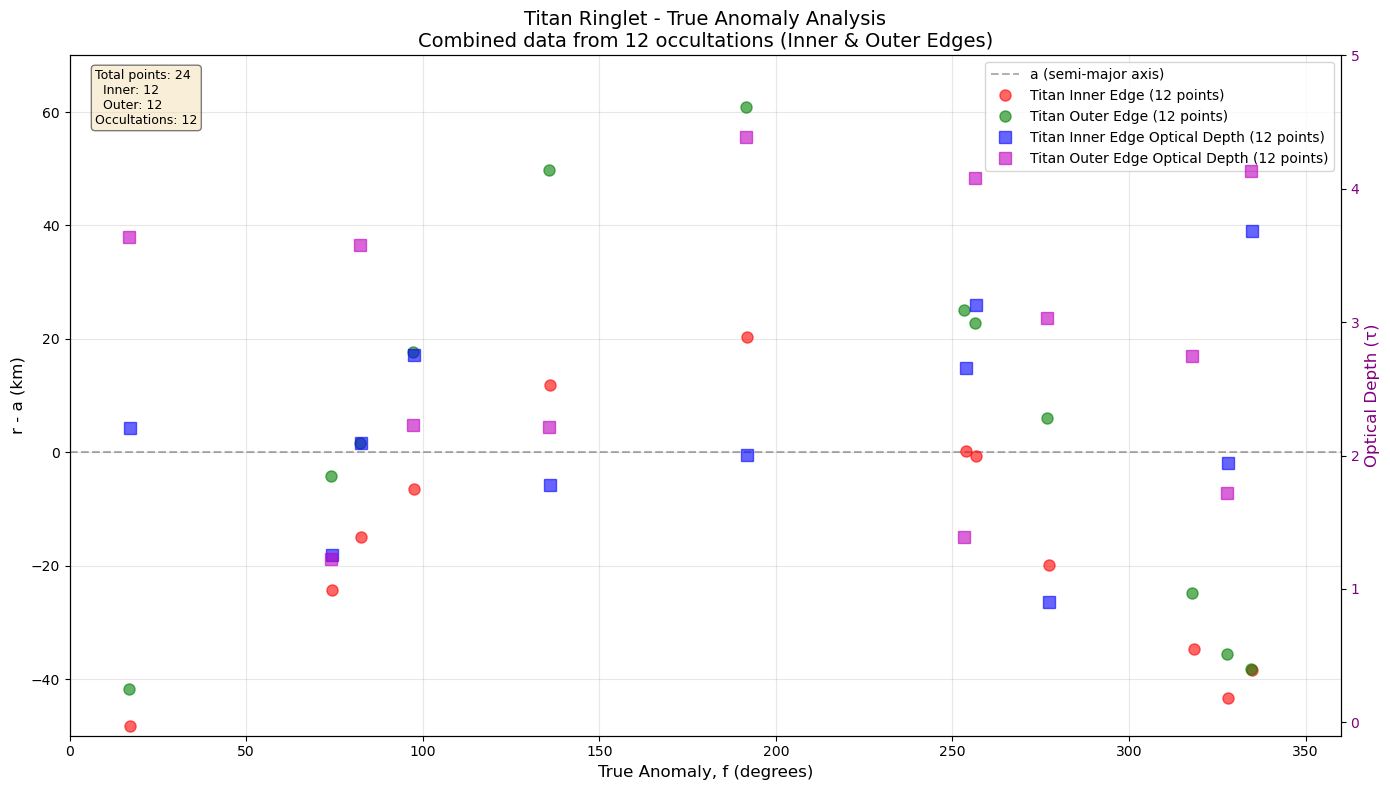

In [10]:
# This section plots optical depth vs true anomaly for Titan ringlet along with the true anomoly vs radial distance
fig, ax1 = plt.subplots(figsize=(14, 8))

# PRIMARY AXIS (LEFT Y-AXIS): r - a (km)
ax1.set_xlabel('True Anomaly, f (degrees)', fontsize=12)
ax1.set_ylabel('r - a (km)', fontsize=12)
ax1.set_xlim(0, 360)
ax1.set_ylim(-50, 70)

# Plot radius data on primary axis
ax1.errorbar(all_true_anomaly_inner, all_radii_inner - a_paper,
             fmt='ro', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1)
ax1.errorbar(all_true_anomaly_outer, all_radii_outer - a_paper, 
             fmt='go', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1)

# SECONDARY AXIS (RIGHT Y-AXIS): Optical Depth (τ)
ax2 = ax1.twinx()
ax2.set_ylabel('Optical Depth (τ)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(-.1, 5)

# Calculate average tau
avg_tau_inner = [(tau_plus + tau_minus) / 2 for tau_plus, tau_minus in zip(all_TAUPLUS_inner, all_TAUMINUS_inner)]
avg_tau_outer = [(tau_plus + tau_minus) / 2 for tau_plus, tau_minus in zip(all_TAUPLUS_outer, all_TAUMINUS_outer)]

# Plot optical depth data on secondary axis
ax2.errorbar(all_true_anomaly_inner, avg_tau_inner,
             fmt='bs', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge Optical Depth ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1)
ax2.errorbar(all_true_anomaly_outer, avg_tau_outer, 
             fmt='ms', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge Optical Depth ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1)

# Formatting
ax1.set_title(f'Titan Ringlet - True Anomaly Analysis\nCombined data from {len(all_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='a (semi-major axis)')
ax1.grid(True, alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=10, loc='best')

# Add text box with statistics
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

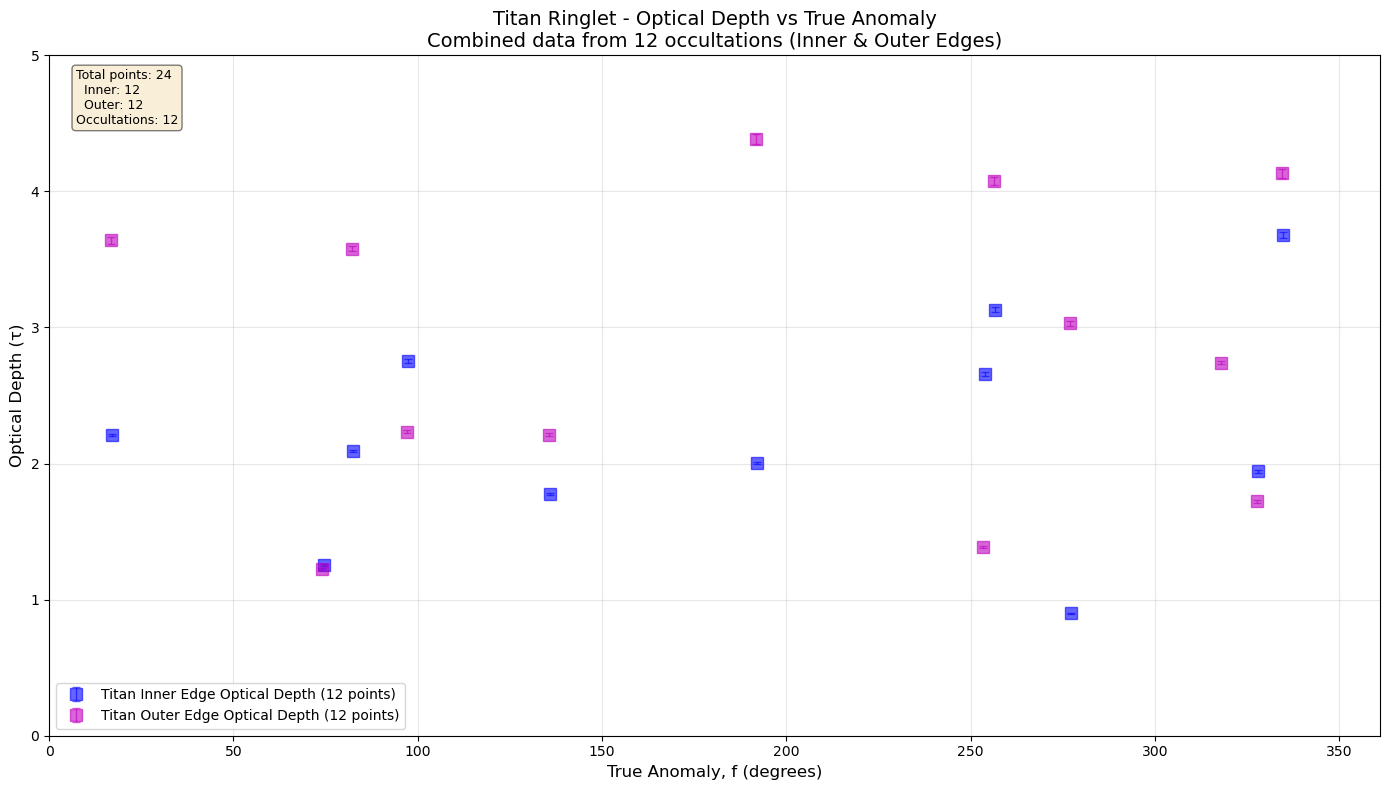


Plot generated with 24 total data points from 12 CSV files
  - Inner edge: 12 points (blue squares)
  - Outer edge: 12 points (magenta squares)


INNER EDGE (sorted by true anomaly):
  f =   17.1°  ->  τ = 2.210
  f =   74.4°  ->  τ = 1.256
  f =   82.4°  ->  τ = 2.092
  f =   97.5°  ->  τ = 2.751
  f =  135.9°  ->  τ = 1.779
  f =  191.9°  ->  τ = 2.003
  f =  253.7°  ->  τ = 2.658
  f =  256.6°  ->  τ = 3.132
  f =  277.2°  ->  τ = 0.900
  f =  318.4°  ->  τ = 5.151
  f =  328.0°  ->  τ = 1.944
  f =  334.7°  ->  τ = 3.682

OUTER EDGE (sorted by true anomaly):
  f =   16.8°  ->  τ = 3.640
  f =   74.1°  ->  τ = 1.223
  f =   82.1°  ->  τ = 3.580
  f =   97.2°  ->  τ = 2.232
  f =  135.7°  ->  τ = 2.213
  f =  191.6°  ->  τ = 4.386
  f =  253.3°  ->  τ = 1.387
  f =  256.3°  ->  τ = 4.077
  f =  276.9°  ->  τ = 3.030
  f =  318.0°  ->  τ = 2.743
  f =  327.6°  ->  τ = 1.722
  f =  334.5°  ->  τ = 4.132


In [24]:
# This section plots just optical depth vs true anomaly for Titan ringlet
plt.figure(figsize=(14, 8))

# Calculate average tau (mean of upper and lower bounds)
avg_tau_inner = [(tau_plus + tau_minus) / 2 for tau_plus, tau_minus in zip(all_TAUPLUS_inner, all_TAUMINUS_inner)]
avg_tau_outer = [(tau_plus + tau_minus) / 2 for tau_plus, tau_minus in zip(all_TAUPLUS_outer, all_TAUMINUS_outer)]

# Error bars: distance from mean to bounds
tau_err_lower_inner = [avg - tau_minus for avg, tau_minus in zip(avg_tau_inner, all_TAUMINUS_inner)]
tau_err_upper_inner = [tau_plus - avg for tau_plus, avg in zip(all_TAUPLUS_inner, avg_tau_inner)]

tau_err_lower_outer = [avg - tau_minus for avg, tau_minus in zip(avg_tau_outer, all_TAUMINUS_outer)]
tau_err_upper_outer = [tau_plus - avg for tau_plus, avg in zip(all_TAUPLUS_outer, avg_tau_outer)]

# Plot inner edge with asymmetric error bars
plt.errorbar(all_true_anomaly_inner, avg_tau_inner, 
             yerr=[tau_err_lower_inner, tau_err_upper_inner],
             fmt='bs', markersize=8, capsize=3, capthick=1, 
             label=f'Titan Inner Edge Optical Depth ({len(all_true_anomaly_inner)} points)', 
             alpha=0.6, elinewidth=1)

# Plot outer edge with asymmetric error bars
plt.errorbar(all_true_anomaly_outer, avg_tau_outer, 
             yerr=[tau_err_lower_outer, tau_err_upper_outer],
             fmt='ms', markersize=8, capsize=3, capthick=1,
             label=f'Titan Outer Edge Optical Depth ({len(all_true_anomaly_outer)} points)', 
             alpha=0.6, elinewidth=1)

# Formatting
plt.xlabel('True Anomaly, f (degrees)', fontsize=12)
plt.ylabel('Optical Depth (τ)', fontsize=12)
plt.title(f'Titan Ringlet - Optical Depth vs True Anomaly\nCombined data from {len(all_csv_names)} occultations (Inner & Outer Edges)', fontsize=14)
plt.xlim(0, 361)
plt.ylim(0, 5)  # Adjust based on your tau range
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)

# Add text box with statistics
total_points = len(all_true_anomaly_inner) + len(all_true_anomaly_outer)
stats_text = f'Total points: {total_points}\n'
stats_text += f'  Inner: {len(all_true_anomaly_inner)}\n'
stats_text += f'  Outer: {len(all_true_anomaly_outer)}\n'
stats_text += f'Occultations: {len(all_csv_names)}'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=9, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nPlot generated with {total_points} total data points from {len(all_csv_names)} CSV files")
print(f"  - Inner edge: {len(all_true_anomaly_inner)} points (blue squares)")
print(f"  - Outer edge: {len(all_true_anomaly_outer)} points (magenta squares)")

print("\n" + "=" * 60)

# Sort by true anomaly to see the pattern more clearly
inner_sorted = sorted(zip(all_true_anomaly_inner, avg_tau_inner))
outer_sorted = sorted(zip(all_true_anomaly_outer, avg_tau_outer))

print("\nINNER EDGE (sorted by true anomaly):")
for f, tau in inner_sorted:
    print(f"  f = {f:6.1f}°  ->  τ = {tau:.3f}")

print("\nOUTER EDGE (sorted by true anomaly):")
for f, tau in outer_sorted:
    print(f"  f = {f:6.1f}°  ->  τ = {tau:.3f}")